In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./datasets/naver_movie_all.csv')
data = data[['document', 'label']]
print(data.shape)
data.head()

(43537, 2)


,document,label
0,내 인생 영화 top3에 등록...,1
1,관람객디지털에 아날로그를 담고있네요 . 누구나의 마음을 위로해 주는 영화,1
2,절대 비공감의 상황 속의 절대 공감,1
3,멜로영화중 여태까지 보지 않았던 새로운 느낌을 준 영화,1
4,관람객소유할 수 없고 사라질 것에 대해 그래도 사랑 할 수 있는 용기가 있는지 묻...,1


In [3]:
train_data, test_data = train_test_split(data, test_size=0.33, random_state=777)

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 29169


In [5]:
train_data[:5] # 상위 5개 출력

,document,label
40869,솔직히 무간도 보다 더 재밌었다.,1
27028,NaN,1
8086,모든 여자가 한 번쯤은 사랑한 남자 바쿠....모든 여자가 결혼하고 싶어할 남자 료...,1
13322,"정치 선동물, 흔해빠진 로맨스 코메디만 찍어내는 한국영화는 반성해라. 스크린 독점 ...",1
40409,이 명작이 평점이 이렇게 낮다니.. 10점 주고 갑니다.,1


In [6]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 14368


In [7]:
test_data[:5]


,document,label
9544,감독님이 그동안 조사했던내용이 이해하기 쉽게 잘 설명되어있어요,1
13026,"관람객오랜만에 흥분되는 영화를 본 것 같음. 연기, 연출, 드라마적 요소 등 완벽",1
17236,신파 심하지않고 소재신선하고 너무좋았어요 부담없이 즐기기에 딱입니다 ㅎㅎ 제가 본 ...,1
25904,와 인간적으로 군대갔다 왔다면서 총한번 쏴보질 못하냐...총질하는데 억지설정으로 지...,0
10755,사쿠라를 엽기적인 그녀로 만들어놨네. 슬픔이. 드러나질않아. 불꽃놀이랑 주제가만 ...,0


### Preprocessing

In [8]:
# 데이터 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(24075, 2)

In [9]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 

C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 24076


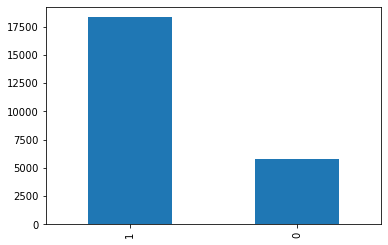

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   5753
1      1  18323


In [13]:
train_data['label'].value_counts()

1    18323
0     5753
Name: label, dtype: int64

In [14]:
print(train_data.isnull().sum())

document    1
label       0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()]

,document,label
27028,NaN,1


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data))

False
24075


In [17]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [18]:
# https://www.unicode.org/charts/PDF/U3130.pdf
# ㄱ ~ ㅎ: 3131 ~ 314E
# ㅏ ~ ㅣ: 314F ~ 3163
# https://www.unicode.org/charts/PDF/UAC00.pdf
# 가 ~ 힣

In [19]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,document,label
40869,솔직히 무간도 보다 더 재밌었다,1
8086,모든 여자가 한 번쯤은 사랑한 남자 바쿠모든 여자가 결혼하고 싶어할 남자 료헤이,1
13322,정치 선동물 흔해빠진 로맨스 코메디만 찍어내는 한국영화는 반성해라 스크린 독점 문제...,1
40409,이 명작이 평점이 이렇게 낮다니 점 주고 갑니다,1
2439,내인생 최악의영화 내용도 없고 아무것도없음 평점은 다 거짓말,0


In [20]:
# 영어로만 작성된 리뷰도 삭제 됨
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    0
label       0
dtype: int64


In [21]:
train_data.loc[train_data.document.isnull()][:5]

,document,label


In [22]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

24075


In [23]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 12666


C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

### Tokenization

In [24]:
# 불용어 제거, 한국어의 조사, 접속사 등 -> 지속적으로 검토하면서 추가해서 삭제
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [25]:
# 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt
okt = Okt()
okt.morphs('2000년이후 최고의 서스펜스... 라고 했지만, 이걸 왜 봤을까', stem = True)

['2000년', '이후', '최고', '의', '서스펜스', '...', '라고', '하다', ',', '이', '걸', '왜', '보다']

In [26]:
# 불용어 제거
# 형태소 토큰화
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [27]:
print(X_train[:3])

[['솔직하다', '무간도', '보다', '더', '재밌다'], ['모든', '여자', '번', '쯤', '사랑', '남자', '바쿠', '모든', '여자', '결혼', '하고', '싶다', '남자', '료헤이'], ['정치', '선', '동물', '흔하다', '빠지다', '로맨스', '코메디', '만', '찍어내다', '한국영', '화', '반성', '스크린', '독점', '문제', '라이', '누구', '놀리다', 'ㅋ', '쓰레기', '영상', '물', '더미', '속', '진주', '같다', '영화']]


In [28]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [29]:
### 정수 인코딩

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '이다': 4, '있다': 5, '좋다': 6, '없다': 7, '너무': 8, '되다': 9, '같다': 10, '다': 11, '관람객': 12, '적': 13, '진짜': 14, '에서': 15, '로': 16, '아니다': 17, '스토리': 18, '않다': 19, '연기': 20, '만': 21, '재밌다': 22, '것': 23, '생각': 24, '정말': 25, '배우': 26, '그': 27, '평점': 28, '나오다': 29, '사람': 30, '안': 31, '보고': 32, '인': 33, '점': 34, '시간': 35, '만들다': 36, '더': 37, '나': 38, '내': 39, '최고': 40, '게': 41, '고': 42, '수': 43, '왜': 44, '못': 45, '자다': 46, '가다': 47, '말': 48, '하고': 49, '까지': 50, '때': 51, '연출': 52, '그냥': 53, '들다': 54, '긴장감': 55, '감독': 56, '모르다': 57, '싶다': 58, '평': 59, '이렇다': 60, '감상': 61, '오다': 62, '정도': 63, '처음': 64, '무섭다': 65, '요': 66, '사랑': 67, '많다': 68, '장면': 69, '마지막': 70, '중': 71, '볼': 72, '거': 73, '감동': 74, '그렇다': 75, '느낌': 76, '주다': 77, '액션': 78, '꼭': 79, '하나': 80, '알다': 81, '영': 82, '내용': 83, '보기': 84, '느끼다': 85, '지루하다': 86, '그리고': 87, 'ㅠㅠ': 88, '저': 89, '인생': 90, '재미있다': 91, '네': 92, '작품': 93, '아깝다': 94, '분': 95, '아쉽다': 96, '다시': 97, '부터': 98, '이렇게': 99, '이해': 100, '많이': 101, '아': 

In [32]:
threshold = 3 # 빈도수가 3회 미만은 제거
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [33]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18243
등장 빈도가 2번 이하인 희귀 단어의 수: 10452
단어 집합에서 희귀 단어의 비율: 57.293208353889156
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.29064583739891


In [34]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7792


In [35]:
import pickle
vocab_size = vocab_size

with open('./save/vocab_size.p', 'wb') as file:    # james.p 파일을 바이너리 쓰기 모드(wb)로 열기
    pickle.dump(vocab_size, file)

In [36]:
# 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환하는 정수 인코딩 과정에서 
# 이보다 큰 숫자가 부여된 단어들은 아예 계산하지 않음
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [37]:
print(X_train[:3])

[[227, 360, 2, 37, 22], [149, 229, 129, 565, 67, 240, 2542, 149, 229, 651, 49, 58, 240, 3063], [1074, 722, 1874, 1230, 338, 706, 6447, 21, 4999, 369, 253, 1929, 896, 2450, 569, 1816, 484, 276, 310, 144, 460, 187, 6448, 10, 1]]


In [38]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 빈 샘플(Empty samples) 제거

In [39]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [40]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

23957
23957


In [41]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

12594
12594


In [42]:
np.save("./save/y_train.npy", y_train)
np.save("./save/y_test.npy", y_test)

### 패딩

리뷰의 최대 길이 : 313
리뷰의 평균 길이 : 15.928079475727344


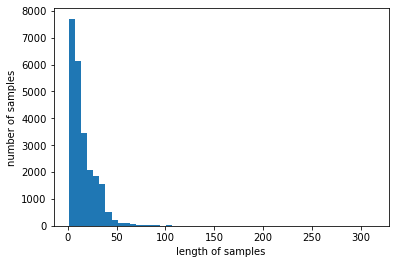

In [43]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [45]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 86.39228617940476


In [46]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [47]:
np.save("./save/X_train.npy", X_train)
np.save("./save/X_test.npy", X_test)